#Two-Stage Detectors
<font color="red"> Tot notebook-ul poate fi rulat pe CPU </font>

### R-CNN
[R-CNN](https://arxiv.org/pdf/1311.2524) este considerat primul model modern de object detection. Acesta separă task-ul de object detection în două părți: propunerea de regiuni care pot conține obiecte (region proposal) și clasificarea acestor regiuni. La clasificare adăugăm și clasa de *no object*.


*   Propunerea de regiuni este realizată de algoritmul selective search, care nu ține de deep learning.
*   Fiecare regiune este trecută printr-un backbone care poate să fie orice CNN (ResNet, MobileNet, arhitecturi custom, etc.). Astfel, sunt extrase feature-uri pentru fiecare regiune.
* Feature-urile fiecărei regiuni sunt trecute prin Support Vector Machines (SVMs) care atribuie o clasă regiunii respective.

Astfel, R-CNN transformă task-ul de object detection intr-o problemă de clasificare. Mare parte din AI ține de cum modelăm problemele. Mai tărziu în acest tutorial vom vedea cum DeTR modelează task-ul de object detection într-un mod total diferit, chiar dacă problema este aceeași.




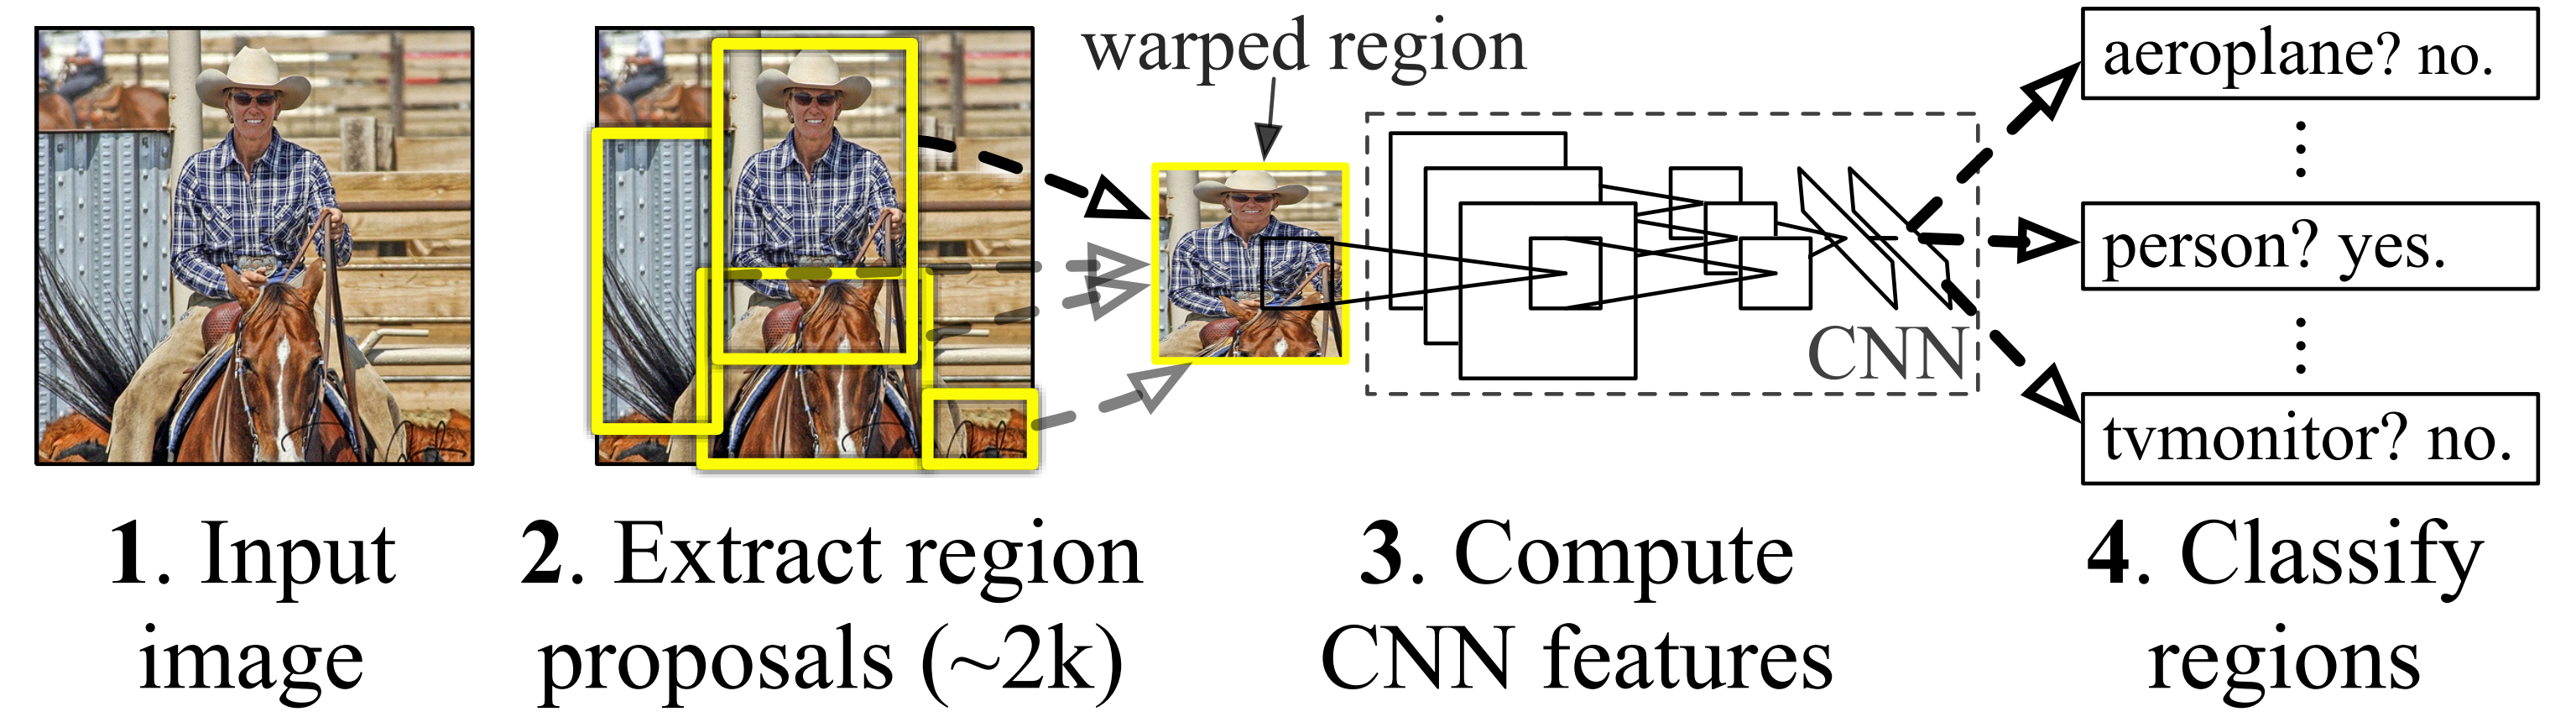

### Fast R-CNN

[Fast R-CNN](https://arxiv.org/pdf/1504.08083) îmbunătățește arhitectura R-CNN mărindu-i viteza și performanța (măsurată ca mAP). Aceasta aduce următoarele schimbări:
- Imaginea inițială este trecută prin backbone pentru a extrage feature maps din ea, iar propunerile de regiuni sunt decupate din aceste feature maps (sună simplu, dar implementarea e puțin mai tricky). Astfel, nu e nevoie să trecem fiecare regiune propusă prin backbone, ci doar imaginea inițială.
- SVM-urile sunt înlocuite de două head-uri (fully-connected layers de data aceasta): unul de clasificare și unul de regresie. Cel de clasificare folosește funcția softmax pentru a da ca output care e probabilitea ca regiunea propusă să aparțină de fiecare clasă în parte, iar cel de regresie ne dă un offset de corectare pentru coordonatele bounding box-urilor. De exemplu, dacă algoritmul de region proposal (selective search) ratează coada unui cățeluș, atunci head-ul de regresie are ocazia de a corecta asta.

Un alt aspect important la Fast R-CNN este că folosește un multi-task loss la antrenare. Asta se datorează faptului că modelul are două head-uri de output care trebuie antrenat concomitent. Un simplu multi-task loss-ul pentru Fast R-CNN ar putea fi:

$ CrossEntropy(ClassificationOutput) + α * MeanSquaredError(RegressionOutput) $,

unde α controlează importanța task-ului de regresie.

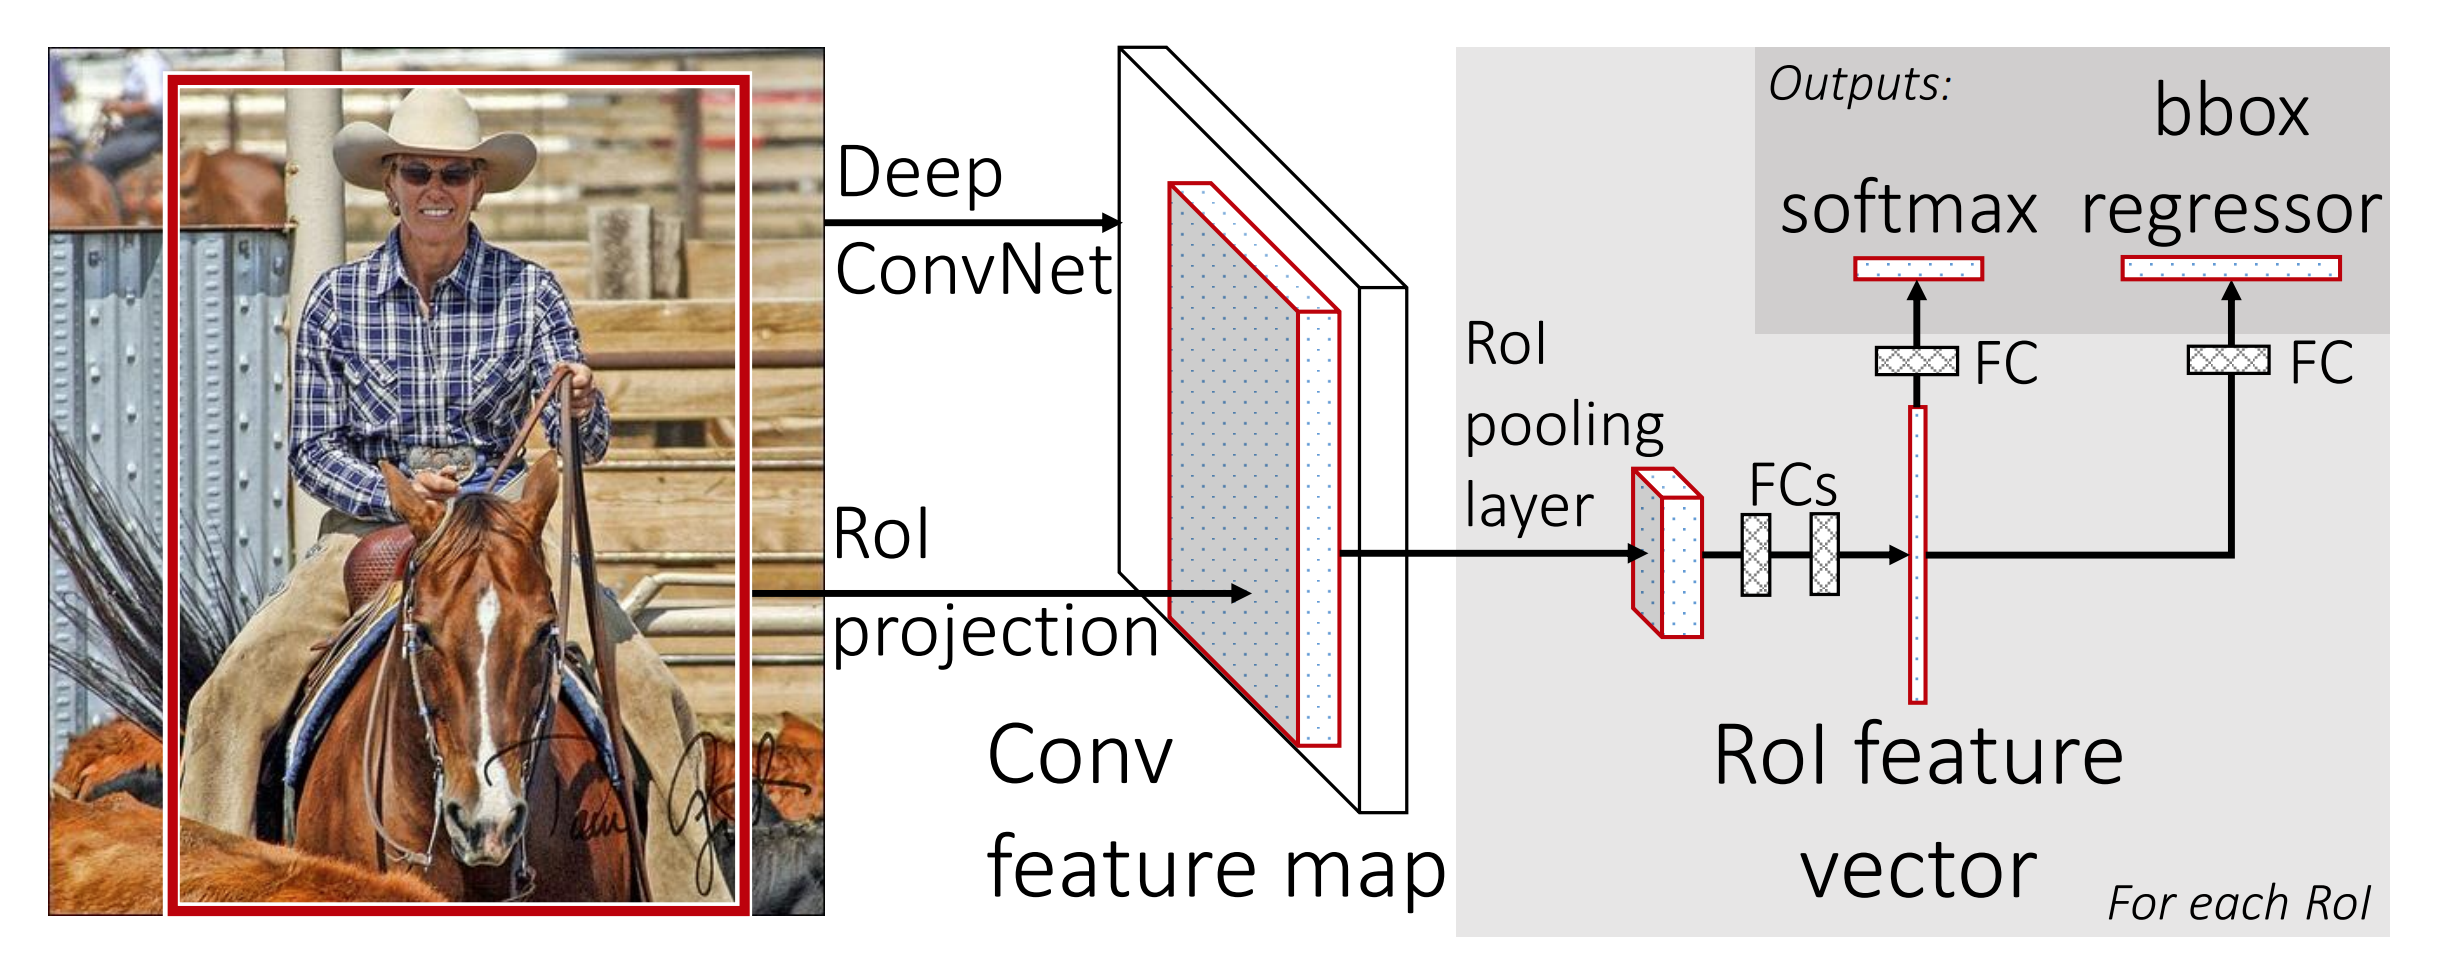

### Faster R-CNN

O mare problemă la Fast R-CNN era faptul că algoritmul de region proposal ocupa cea mai mare parte din runtime la inferență. De asemenea, algoritmul nu putea învăța din date. [Faster R-CNN](https://arxiv.org/pdf/1506.01497) rezolvă această problemă înlocuind algoritmul de selective search cu un Region Proposal Network. Practic, de data aceasta avem:
- CNN backbone - extrage feature maps din imaginea inițială.
- Region Proposal Network (RPN) - primește feature maps din backbone ca input și returnează coordonate pentru regiunile propuse
- Un modul de clasificare și corectare a bounding box-urilor care este chiar partea din Fast R-CNN care se află în caseta gri din imaginea de mai sus.

Toate cele trei componente de mai sus sunt rețele neuronale, deci sunt antrenabile. Exista mai multe metode de a antrena întreaga rețea Faster R-CNN, câteva dintre ele sunt:
- totul simultan
- mai întâi modulul RPN și după modulul din Fast R-CNN (dar ce facem cu backbone-ul?)
- alternăm antrenarea separată a celor două module

O discuție mai exitinsă despre modul de antrenare se află în secțiunea 3.2 din [articolul original](https://arxiv.org/pdf/1506.01497). Faster R-CNN nu este doar mai rapid, ci are și o performanță mai mare în benchmark-uri decât modele discutate anterior.

Există și alte îmbunătățiri aduse arhitecturilor two-stage, cum ar fi adăugarea unui Feature Pyramid Network (FPN) în backbone, dar acestea depășesc scopul tutorialului.


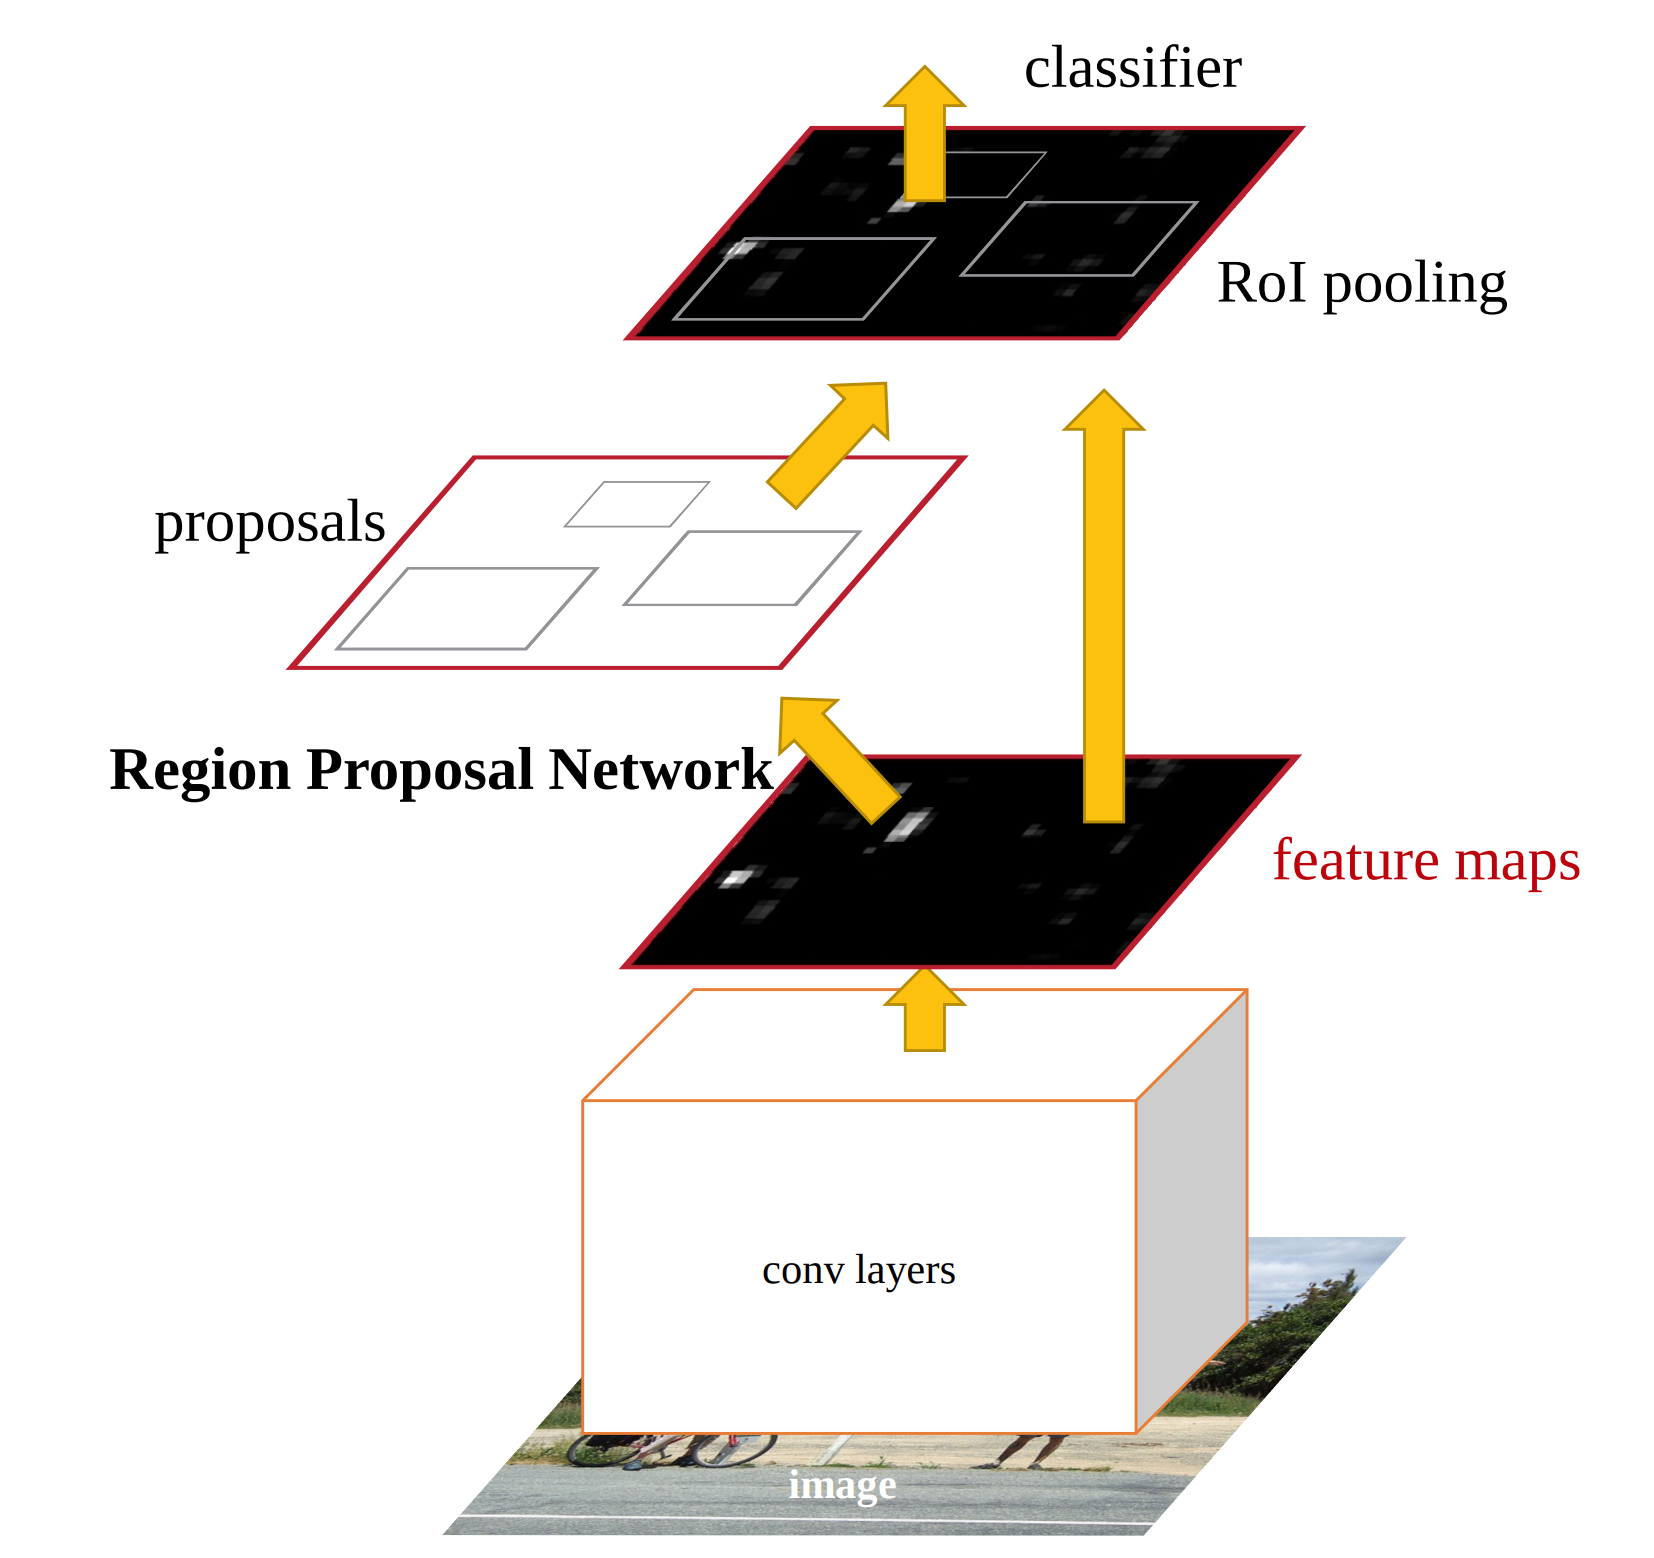

### Partea practică

In [ ]:
!pip install supervision

import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import OxfordIIITPet
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

import random
import numpy as np
import matplotlib.pyplot as plt
from supervision import Detections
import supervision.metrics as sv


Vom folosi tot dataset-ul [OxfordIIITPet](https://www.robots.ox.ac.uk/~vgg/data/pets/), la fel ca în notebook-ul introductiv. De asemenea, vom folosi doar o parte din dataset pentru a grăbi puțin lucrurile.

In [ ]:
random.seed(42)

def convert_segmentation_mask_to_bounding_box(target):
  label, mask = target
  mask = np.array(mask)

  indices = np.argwhere(mask == 3)
  if len(indices) == 0:
    indices = np.argwhere(mask==2)
  indices_y, indices_x = indices[:, 0], indices[:, 1]

  ymin, ymax = indices_y.min(), indices_y.max()
  xmin, xmax = indices_x.min(), indices_x.max()

  return {'label': label, 'bbox': [xmin, ymin, xmax, ymax]}


dataset = OxfordIIITPet(root='root/oxford-iiit-pet',
                        split='trainval',
                        target_types=('binary-category', 'segmentation'),
                        target_transform=convert_segmentation_mask_to_bounding_box,
                        download=True)

subset_indices = random.sample(range(len(dataset)), 500)

dataset = Subset(dataset, subset_indices)

Vizualizăm iar o parte din dataset, până aici nu ar trebui sa fie nimic nou.

In [ ]:
def label_to_class(label: int) -> str:
  return 'dog' if label == 1 else 'cat'

def show_multiple_images_with_bbox():
  # Afișează mai multe imagini + bounding box-urile respective

  fig, axes = plt.subplots(4, 4, figsize=(12, 12))
  axes = axes.flatten() # facem asta doar pentru a itera mai ușor prin subplot-uri

  for i, ax in enumerate(axes):
      img, target = dataset[i]
      label = target['label']
      bbox = target['bbox']

      # Imagine + bbox
      ax.imshow(img)
      if bbox is not None:
        xmin, ymin, xmax, ymax = bbox
        ax.add_patch(
            plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                          fill=False, edgecolor='red', linewidth=2)
        )

      ax.axis("off")
      ax.set_title(label_to_class(label))

  plt.show()

show_multiple_images_with_bbox()

Acum vom folosi un model Faster R-CNN deja implementat în Pytorch https://docs.pytorch.org/vision/main/models/faster_rcnn.html. Alegem versiunea cu un backbone MobileNetV3Large320 care conține și modulul FPN mentionat anterior. Modelul este preantrenat pe [COCO](https://cocodataset.org/#home), benchmark-ul principal de object detection. Deoarece COCO conține deja clasele "cățel" și "pisică", putem încerca să folosim modelul pe dataset-ul nostru fără a-l reantrena.

In [ ]:
model = fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1, # specificăm faptul că vrem varianta preantrenată pe COCO
    trainable_backbone_layers=0 # nu antrenăm modelul în acest notebook
    )

# Modelul se comportă diferit la inference time față de train time. Acest fapt
# se poate datora design-ului (de exemplu, modelul nostru are ca output si
# valorile loss-ului la train time) sau poate fi cauzat de anumite layere,
# precum cele de Batch Normalization (prezente în foarte multe modele).
model.eval()

# print() # decomentați linia aceasta dacă vreți să nu fie afișată structura modelului

După cum puteți observa mai sus, înaintea backbone-ului exista si un modul numit transform. Acesta nu face parte din modelul propriu-zis, ci e mai mult un pas de preprocesare. Scopul lui este de a normaliza imaginile și de a le aduce la rezoluția care a fost folosită la antrenarea modelului (cea minimă este 320, de aici vine și numele modelului). Veți învăța la statistică conceptul de normalizare, dar, pe scurt, normalizarea duce pixelii imaginii în intervalul [-1, 1] și face ca suma lor să fie 0. Acest lucru ajută la stabilizarea modelului.

În următoarea casetă mai utilizam un obiect transforms, puteți afla ce face din [documentația PyTorch](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn.html#torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights). Este foarte important să folosim documentații pentru a ști exact ce fac funcțiile și obiectele din diverse limbaje, biblioteci si framework-uri.  

Un alt aspect important când vine vorba de machine learning este preprocesarea datelor. Când folosim un model pentru inferență, input-ul trebuie supus acelorași preprocesări care au fost folosite și la antrenare.

In [ ]:
# Preprocesarea imaginilor
faster_rcnn_transforms = FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1.transforms()
input_images = [faster_rcnn_transforms((dataset[i])[0]) for i in range(8)]

# Inferență
predictions = model(input_images)

# Afișăm output-ul modelului pentru a înțelege cum îl putem folosi. Se poate
# observa că fiecare imagine are asociat un dicționar care conține informații
# despre MAI MULTE predicții. NMS a fost aplicat deja în interiorul modelului.
# Predicțiile care sunt în plus sunt pentru clase din COCO care nu sunt adnotate
# și în dataset-ul nostru.
predictions[:2]

In [ ]:
# Folosim modelul preantrenat pentru inferență pe primele 8 imagini din dataset
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img, _ = dataset[i]
    ax.imshow(img)
    ax.axis('off')

    # Extragem predicțiile pentru imaginea i
    prediction_dict = predictions[i]
    boxes, labels, scores = prediction_dict['boxes'], prediction_dict['labels'], prediction_dict['scores']

    # Păstram doar predicțiile pentru clasele pisică (cod 17) și cățel (cod 18)
    # care au un confidence score rezonabil
    for box, label, score in zip(boxes, labels, scores):
      if label not in (17, 18):
        continue

      color = 'red' if label == 17 else 'green' # chenar roșu pentru pisici și verde pentru căței
      if score > 0.5:
        box = box.detach()
        xmin, ymin, xmax, ymax = box
        ax.add_patch(
          plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, edgecolor=color, linewidth=2)
        )

plt.show()

Modelul preantrenat pare să se descurce destul de bine, dar a ratat un cățel. Acum vom reinițializa dataset-ul și îl vom folosi pentru validare. Vom inițializa și un dataloader al cărui rol este eficientizarea transferului imaginilor de pe HDD/SSD în RAM.

In [ ]:
dataset = OxfordIIITPet(root='root/oxford-iiit-pet',
                          split='trainval',
                          transform=faster_rcnn_transforms, # transformări pentru input (imagini)
                          target_types=('binary-category', 'segmentation'),
                          target_transform=convert_segmentation_mask_to_bounding_box, # transformări pentru target
                          download=False)

dataset = Subset(dataset, subset_indices) # folosim indicii generați anterior

train_set_size = 400
val_set_size= 100
_, val_dataset = random_split(dataset, [train_set_size, val_set_size]) # avem nevoie doar de setul de validare

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2,
    collate_fn=lambda batch: tuple(zip(*batch))
)


In [ ]:
def evaluate_mAP(model, dataloader):
  # Această funcție folosește package-ul supervision pentru a calcula (pentru
  # toate imaginile din dataloader) mAP@50 și mAP@50:95, metrici care au fost
  # discutate în notebook-ul introductiv. Dacă nu ați înțeles ce reprezintă,
  # atunci vă încurajez să puneți întrebări sau să revizitați notebook-ul.
  # Important este să înțelegi cum functionează mAP, nu package-ul supervision.
  model.eval()

  metric = sv.MeanAveragePrecision()

  with torch.no_grad():
    for i, (images, targets) in enumerate(dataloader):
      predictions = model(images)

      # supervision folosește propriul format, partea aceasta nu este importantă
      predictions = [
          Detections(
              xyxy=pred['boxes'].numpy(),
              class_id=pred['labels'].numpy(),
              confidence=pred['scores'].numpy())
          for pred in predictions
          ]

      # Modelul prezice codurile pentru clase folosite în COCO pentru căței și
      # pisici (17 și 18), dar target-urile din dataset-ul nostru au valori 0 și 1,
      # așa că trebuie să fim atenți ce valori primește parametrul class_id.
      targets = [
          Detections(
              xyxy=np.array(target['bbox']).reshape(-1, 4),
              class_id=np.array([17 if target['label'] == 0 else 18]))
          for target in targets
          ]

      metric.update(predictions, targets)
      print(f'Processed {i+1}/{len(dataloader)} batches')

    mAP = metric.compute()
    return mAP.map50, mAP.map50_95

map50, map50_95 = evaluate_mAP(model, val_loader)
print(f'mAP@50={map50} \nmAP@50:95={map50_95}')

Știm că mAP@50:95 este mai strict decât mAP@50 și asta se reflectă și în rezultatele noastre. Totuși, dacă diferența aceasta se datorează faptului că dataset-ul nostru are erori de adnotare? Poate că modelul nostru găsește bounding box-uri mai potrivite decât cele din dataset pentru unele animale. Acesta este un caz în care metricile de evaluare nu ne ajută, așa că cea mai pragmatică idee ar fi să facem un plot cu multe imagini, în care să desenăm predicțiile si ground truth-urile. Ați văzut deja cum putem face predicții și plot-uri, așa că vă invit să completați funcția de mai jos. Puteți să folosiți documentații sau să vă uitați la fragmente de cod din acest notebook sau din cel anterior.

In [ ]:
# Exercițiu

def show_predictions_against_ground_truths(model, dataset):

  #---------------------------------------------
  # Rezolvarea exercițiului




  #---------------------------------------------
  plt.show()

show_predictions_against_ground_truths(model, val_dataset)